In [1]:
import os
import pandas as pd 
import numpy as np 

# Data preprocessors
from sklearn.utils import shuffle 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

# Deep Learning Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAvgPool1D, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Visualization
import matplotlib.pyplot as plt

# Dumping
import joblib 

In [2]:
# import local module found in another folder
import sys
sys.path.append('../')
from preprocessing import preprocessing_pipeline
preprocessor = preprocessing_pipeline.PreprocessingPipeline()

In [3]:
# Visualization function

def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [4]:
# Data extraction function
def extract_data(DATA_PATH):
    files = [file for file in os.listdir(DATA_PATH) if os.path.isfile(os.path.join(DATA_PATH, file))]
    combined_data = pd.DataFrame()
    for file in files:
        file_path = os.path.join(DATA_PATH, file)
        df = pd.read_csv(file_path, delimiter='\t')
        combined_data = pd.concat([combined_data, df], ignore_index=True)
    return combined_data

In [5]:
# Modify the path and extract the data
data_path = '../data/'
data = extract_data(DATA_PATH=data_path)

In [6]:
data = shuffle(data)
data = data.dropna()
data.head()

,headline,content,category,date,link
1046,Baalli Sammuu adoochu kuntaalli 32 tohatame,Godina giddugaleessa Goondar aanaa Taachi Ad...,biiznasii,2021-07-04,https://www.fanabc.com/afaanoromoo/baalli-samm...
4224,Gabreheel Jeesuus gara Arsenaal imale,Arsenaal taphataa sarara fuulduraa Biraazil ...,ispoortii,2022-07-04,https://www.fanabc.com/afaanoromoo/gabreeel-je...
587,Baankiin Misoomaa Ityoophiyaa kurmaana jalqaba...,- Baankiin Misoomaa Ityoophiyaa kurmaana jalqa...,biiznasii,2022-10-28,https://www.fanabc.com/afaanoromoo/baankiin-mi...
804,Ityoophiyaatti dhaabbilee Maallaqaa naannoo Ba...,Fandiin Misooma Qonnaa Idila Addunyaa fi Gam...,biiznasii,2021-05-28,https://www.fanabc.com/afaanoromoo/ityoophiyaa...
3016,Addunyaarratti lakkoofsi namoota covid-19 qaba...,Addunyaarratti lakkoofsi namoota vaayrasii k...,idil_addunyaa,2021-01-04,https://www.fanabc.com/afaanoromoo/addunyaarra...


In [7]:
data["text"] = (data["headline"] + data["content"]).apply(preprocessor.preprocess)

In [8]:
data.head()

,headline,content,category,date,link,text
1046,Baalli Sammuu adoochu kuntaalli 32 tohatame,Godina giddugaleessa Goondar aanaa Taachi Ad...,biiznasii,2021-07-04,https://www.fanabc.com/afaanoromoo/baalli-samm...,baalli sammuu adoochu kuntaalli 32 tohatame go...
4224,Gabreheel Jeesuus gara Arsenaal imale,Arsenaal taphataa sarara fuulduraa Biraazil ...,ispoortii,2022-07-04,https://www.fanabc.com/afaanoromoo/gabreeel-je...,gabreheel jeesuu gara arsenaal imale arsenaal ...
587,Baankiin Misoomaa Ityoophiyaa kurmaana jalqaba...,- Baankiin Misoomaa Ityoophiyaa kurmaana jalqa...,biiznasii,2022-10-28,https://www.fanabc.com/afaanoromoo/baankiin-mi...,baankii misoomaa ityoophiyaa kurmaa jalqabaat ...
804,Ityoophiyaatti dhaabbilee Maallaqaa naannoo Ba...,Fandiin Misooma Qonnaa Idila Addunyaa fi Gam...,biiznasii,2021-05-28,https://www.fanabc.com/afaanoromoo/ityoophiyaa...,ityoophiyaat dhaabbilee maallaqaa baadiyaa olu...
3016,Addunyaarratti lakkoofsi namoota covid-19 qaba...,Addunyaarratti lakkoofsi namoota vaayrasii k...,idil_addunyaa,2021-01-04,https://www.fanabc.com/afaanoromoo/addunyaarra...,addunyaarrat lakkoof namo covid 19 qabamani mi...


In [9]:
# Convert the labels to numerical values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(data['category'])

In [10]:
# Split the data int to training, validation and testing sets
X_train_temp, X_test, y_train_temp, y_test = train_test_split(data['text'], encoded_labels, test_size=0.1, random_state=0, stratify=encoded_labels)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.1, random_state=0, stratify=y_train_temp)

In [11]:
# add data length row
data['content_len'] = data['content'].apply(lambda x: len(x.split()))
# now let us calcualte the mean value
mean = np.mean(data['content_len'])
print(mean) # will be used in tokenization

106.91143966547192


In [12]:
# Tokenization
max_length = 150
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post', truncating='post')

In [18]:
# Build and Train Neural Network Model
print(len(label_encoder.classes_))
model = Sequential(
    [
        Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=16, input_length=max_length),
        GlobalAvgPool1D(),
        Dense(16, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')
    ]
)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

6
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 16)           697504    
                                                                 
 global_average_pooling1d_1  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 6)                 102       
                                                                 
Total params: 697878 (2.66 MB)
Trainable params: 697878 (2.66 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
history = model.fit(X_train_padded, y_train, epochs=100, validation_data=(X_val_padded, y_val))

Epoch 1/100
170/170 [==============================] - 2s 8ms/step - loss: 1.7054 - accuracy: 0.2877 - val_loss: 1.5746 - val_accuracy: 0.3814
Epoch 2/100
170/170 [==============================] - 1s 6ms/step - loss: 1.3715 - accuracy: 0.5416 - val_loss: 1.1937 - val_accuracy: 0.6650
Epoch 3/100
170/170 [==============================] - 1s 6ms/step - loss: 0.9599 - accuracy: 0.7579 - val_loss: 0.8397 - val_accuracy: 0.7794
Epoch 4/100
170/170 [==============================] - 1s 6ms/step - loss: 0.6374 - accuracy: 0.8383 - val_loss: 0.6128 - val_accuracy: 0.8524
Epoch 5/100
170/170 [==============================] - 1s 6ms/step - loss: 0.4377 - accuracy: 0.8842 - val_loss: 0.4896 - val_accuracy: 0.8557
Epoch 6/100
170/170 [==============================] - 1s 6ms/step - loss: 0.3166 - accuracy: 0.9128 - val_loss: 0.4205 - val_accuracy: 0.8640
Epoch 7/100
170/170 [==============================] - 1s 6ms/step - loss: 0.2392 - accuracy: 0.9399 - val_loss: 0.3820 - val_accuracy: 0.8773

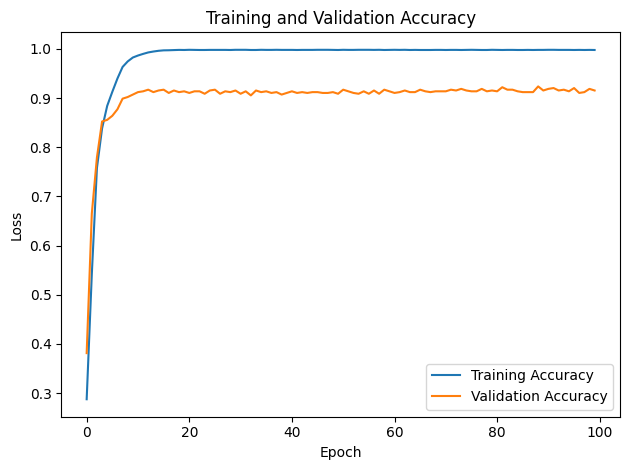

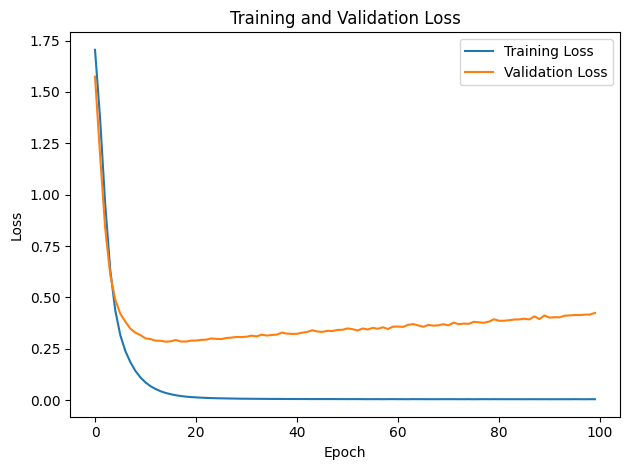

In [20]:
# Evaluate Neural Network Model
plot_accuracy(history)
plot_loss(history)

In [21]:
y_pred = model.predict(X_test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)


# Print classification report
print(classification_report(y_test, y_pred_classes))

21/21 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.91      0.88      0.90       113
           1       0.81      0.88      0.84        81
           2       0.91      0.94      0.92       170
           3       0.98      0.98      0.98       117
           4       0.89      0.89      0.89       150
           5       0.93      0.67      0.78        39

    accuracy                           0.90       670
   macro avg       0.90      0.87      0.89       670
weighted avg       0.91      0.90      0.90       670



In [22]:
label_encoder.classes_

array(['biiznasii', 'fayyaa', 'idil_addunyaa', 'ispoortii',
       'oduu_biyya_keessaa', 'teeknooloojii'], dtype=object)

In [23]:
accuracy_score(y_test, y_pred_classes)

0.9044776119402985

In [ ]:
# Technology has the least F1-Score (0.78), idil_addunyaa has the highest F-Score (0.98)
# Possible reasons is Class Embalance